In [45]:
!pip install numpy
import pandas as pd
df = pd.read_csv("synthetic_car_data.csv")
df.head
df['Timestamp'] = df['Timestamp'].astype(str)

# Strip any leading/trailing whitespace
df['Timestamp'] = df['Timestamp'].str.strip()

# Convert the 'Timestamp' column to datetime, coercing errors
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Check for any 'NaT' values that failed to convert
invalid_dates = df[df['Timestamp'].isna()]
if not invalid_dates.empty:
    print("Entries that could not be converted:")
    print(invalid_dates)

# Verify the conversion
print(df.dtypes)
print(df.head())
df['Minutes'] = df['Timestamp'].dt.minute
print(df.head())





Defaulting to user installation because normal site-packages is not writeable
Timestamp    datetime64[ns]
Car                   int64
dtype: object
            Timestamp  Car
0 2023-08-14 00:00:00   12
1 2023-08-14 00:01:00   20
2 2023-08-14 00:02:00   17
3 2023-08-14 00:03:00   19
4 2023-08-14 00:04:00   17
            Timestamp  Car  Minutes
0 2023-08-14 00:00:00   12        0
1 2023-08-14 00:01:00   20        1
2 2023-08-14 00:02:00   17        2
3 2023-08-14 00:03:00   19        3
4 2023-08-14 00:04:00   17        4


In [46]:
import numpy as np
msk = (df.index < len(df)-50)
df_train = df[msk].copy()
df_test= df[~msk].copy()





In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_train.set_index("Minutes")

print(df_train.dtypes)
print(df_train.head())



Timestamp    datetime64[ns]
Car                   int64
Minutes               int32
dtype: object
            Timestamp  Car  Minutes
0 2023-08-14 00:00:00   12        0
1 2023-08-14 00:01:00   20        1
2 2023-08-14 00:02:00   17        2
3 2023-08-14 00:03:00   19        3
4 2023-08-14 00:04:00   17        4


ACF Values: [ 1.         -0.00281641  0.00450164 ... -0.01804771  0.0065339
 -0.01536165]
PACF Values: [ 1.         -0.00281689  0.00449526 ... -0.07714881  0.1207242
  0.08886781]


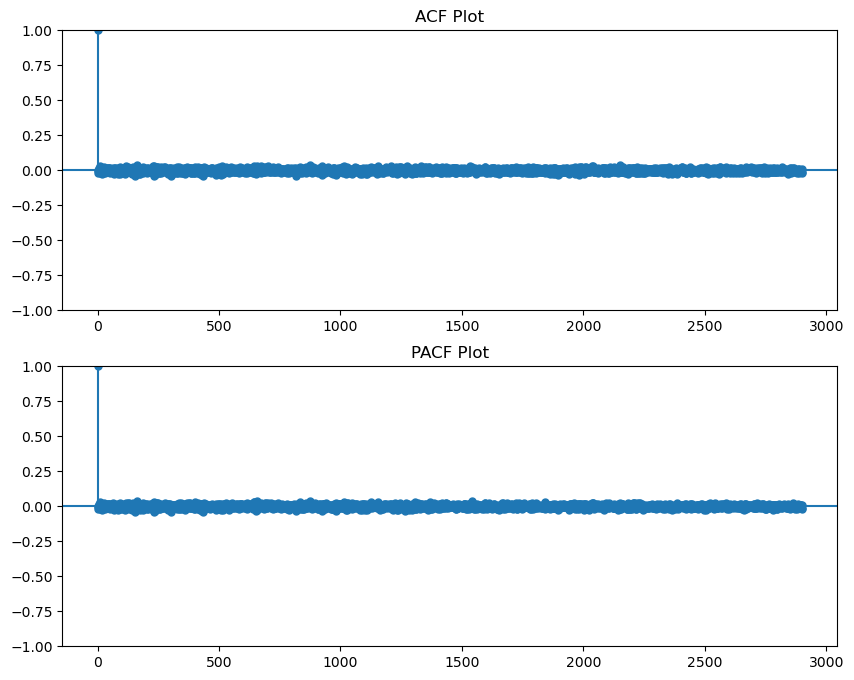

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Assuming df_train is your DataFrame
max_lags = 2900  # Set to the maximum number of lags that works

# Calculate ACF and PACF values
acf_values = acf(df_train["Car"], nlags=max_lags)
pacf_values = pacf(df_train["Car"], nlags=max_lags)

# Store in variables
acf_original = acf_values
pacf_original = pacf_values

# Print the ACF and PACF values
print("ACF Values:", acf_original)
print("PACF Values:", pacf_original)

# Plot ACF with the current number of lags
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_train["Car"], lags=max_lags, ax=ax[0])
ax[0].set_title('ACF Plot')

# Plot PACF with the current number of lags
plot_pacf(df_train["Car"], lags=max_lags, ax=ax[1])
ax[1].set_title('PACF Plot')

plt.show()



In [49]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train["Car"])
print(f'p-value: {adf_test[1]}')

p-value: 0.0


<Axes: >

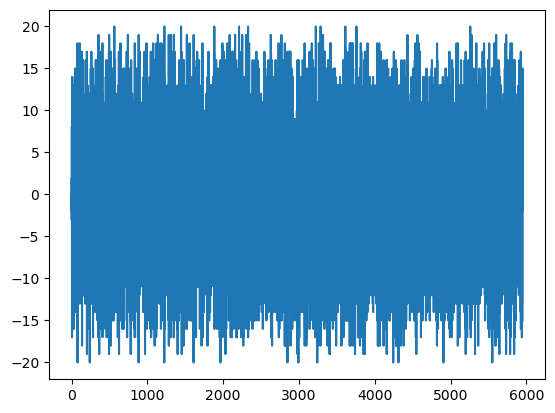

In [50]:
df_train_diff = df_train["Car"].diff().dropna()
df_train_diff.plot()

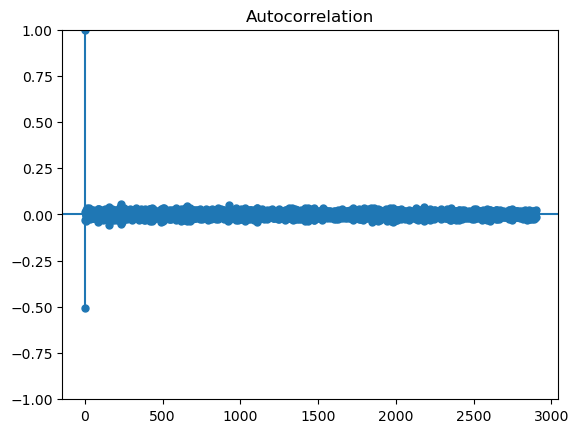

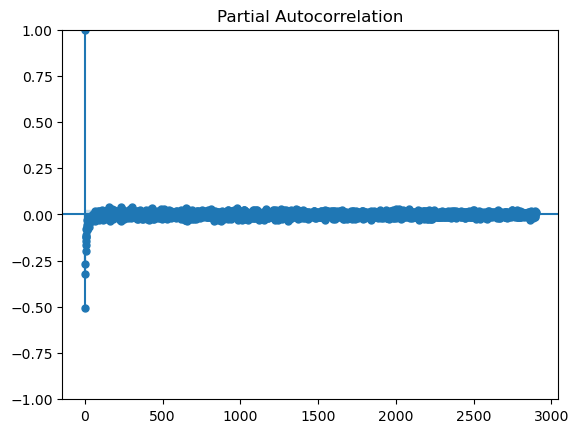

In [51]:
acf_diff = plot_acf(df_train_diff,lags=max_lags)

pacf_diff = plot_pacf(df_train_diff,lags=max_lags)

In [52]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.0


In [53]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train["Car"], order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Car   No. Observations:                 5950
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -20058.338
Date:                Thu, 15 Aug 2024   AIC                          40122.676
Time:                        16:57:22   BIC                          40142.749
Sample:                             0   HQIC                         40129.650
                               - 5950                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6653      0.013    -51.029      0.000      -0.691      -0.640
ar.L2         -0.3211      0.013    -24.466      0.000      -0.347      -0.295
sigma2        49.6824      1.136     43.732      0.0

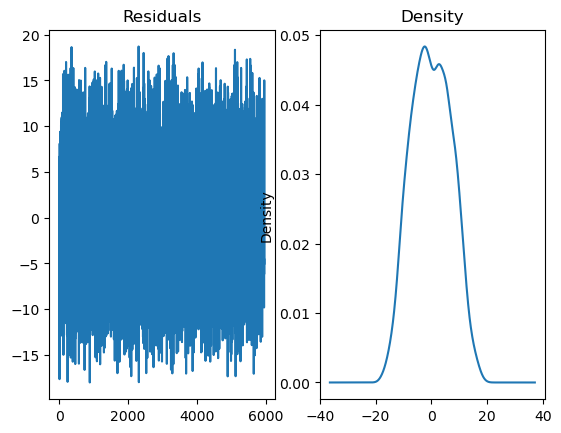

In [54]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

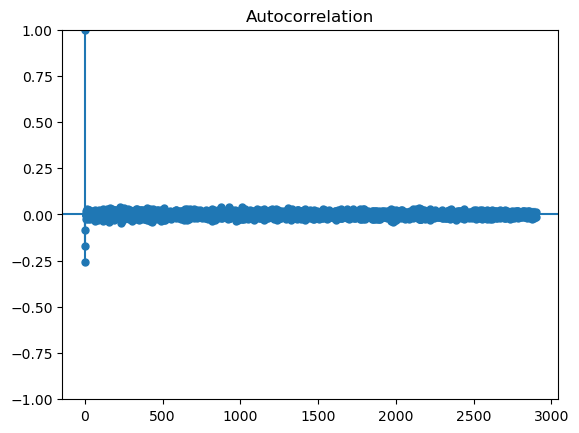

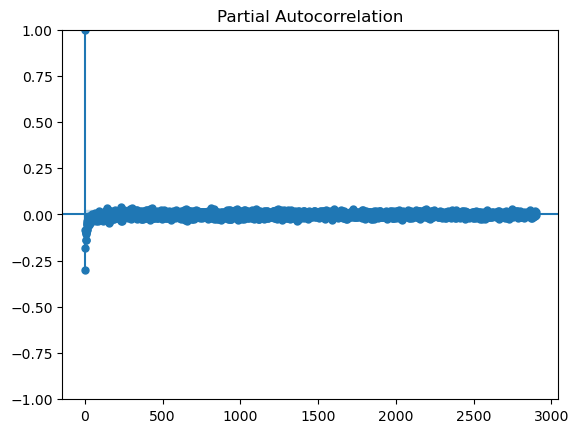

In [55]:
acf_res = plot_acf(residuals,lags=max_lags)

pacf_res = plot_pacf(residuals,lags=max_lags)

<Axes: >

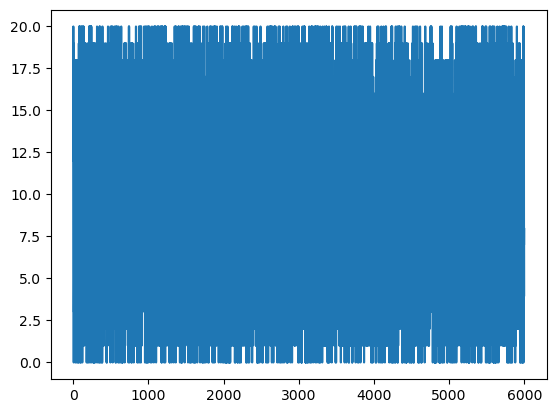

In [56]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df["Car"].plot()

In [57]:
!pip install pmdarima
import pmdarima as pm
auto_arima = pm.auto_arima(df_train["Car"], stepwise=False, seasonal=False)
auto_arima

Defaulting to user installation because normal site-packages is not writeable


ARIMA(order=(5, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [58]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5950
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -19686.928
Date:                Thu, 15 Aug 2024   AIC                          39385.855
Time:                        17:03:45   BIC                          39426.002
Sample:                             0   HQIC                         39399.803
                               - 5950                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1816      0.013     14.007      0.000       0.156       0.207
ar.L2          0.1920      0.013     14.815      0.000       0.167       0.217
ar.L3          0.1677      0.013     12.842      0.000       0.142       0.193
ar.L4          0.2056      0.013     15.966      0.000       0.180       0.231
ar.L5          0.1832      0.013     14.149      0.000       0.158       0.209
sigma2        43.7799      1.058     41.393      0.000      41.707      45.853
===================================================================================
Ljung-Box (L1) (Q):                   9.34   Jarque-Bera (JB):               193.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.03
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

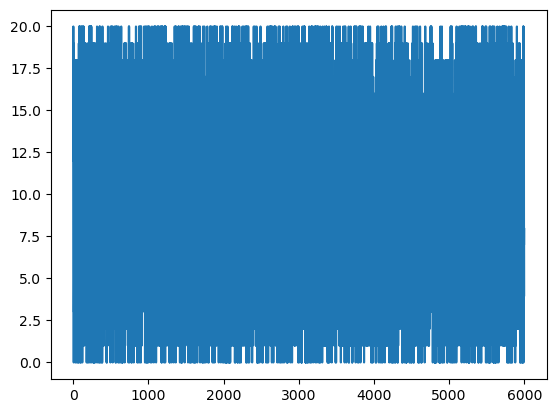

In [59]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df["Car"].plot()

In [60]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test["Car"], forecast_test)
mape = mean_absolute_percentage_error(df_test["Car"], forecast_test)
rmse = np.sqrt(mean_squared_error(df_test["Car"], forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 5.74498646532915
mape - manual: 1810097213506827.0
rmse - manual: 7.253498229747485


In [61]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test["Car"], forecast_test_auto)
mape = mean_absolute_percentage_error(df_test["Car"], forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test["Car"], forecast_test_auto))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 7.366585527352093
mape - manual: 716682301839948.1
rmse - manual: 9.332691246624496
